In [1]:
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_changepoints(df, algorithm, plot=False):
    if algorithm == 'Pelt':
        import ruptures as rpt
        points = rpt.Pelt(model='rbf').fit_predict(df, pen=5)
        points = points[:-1]
        print("Predicted by {}:\n{}".format(algorithm, points))
    
    elif algorithm == 'Prophet':
        from fbprophet import Prophet
        prophet = df.copy().reset_index()
        prophet.columns = (['ds', 'y'])
        m = Prophet().fit(prophet)
        points = list(m.changepoints.index)
        print("Predicted by {}:\n{}".format(algorithm, points))
        
    if plot == True:
        %matplotlib inline
        sns.set_style('whitegrid')
        colors = sns.color_palette('deep', 8)
        sns.set_palette(colors)
        
        fig, ax = plt.subplots(figsize=(17,6), dpi=200)
        ax.plot(
            df.index.values,
            df[df.columns[0]],
            color=colors[0]
        )
        for pt in points:
            ax.axvline(
                x=df.index.values[pt],
                color=colors[2],
                linewidth=1.5,
                linestyle='dashed'
            )
        ax.set_title(
            "Changepoints detected by {} algorithm".format(algorithm),
            size=16
        )
        ax.set_ylabel("USD", size=12)
        ax.set_xlabel("Date", size=12)
        plt.show()
        
    return points

In [3]:
raw = pd.read_json('df.json', orient='split')
ts = pd.DataFrame(raw.eth_close.copy())
ts.head()

,eth_close
2015-08-06,3.00
2015-08-07,1.20
2015-08-08,1.20
2015-08-09,1.20
2015-08-10,0.99


Predicted by Pelt:
[630, 660, 835, 860, 880, 910, 950, 985, 1040, 1100]


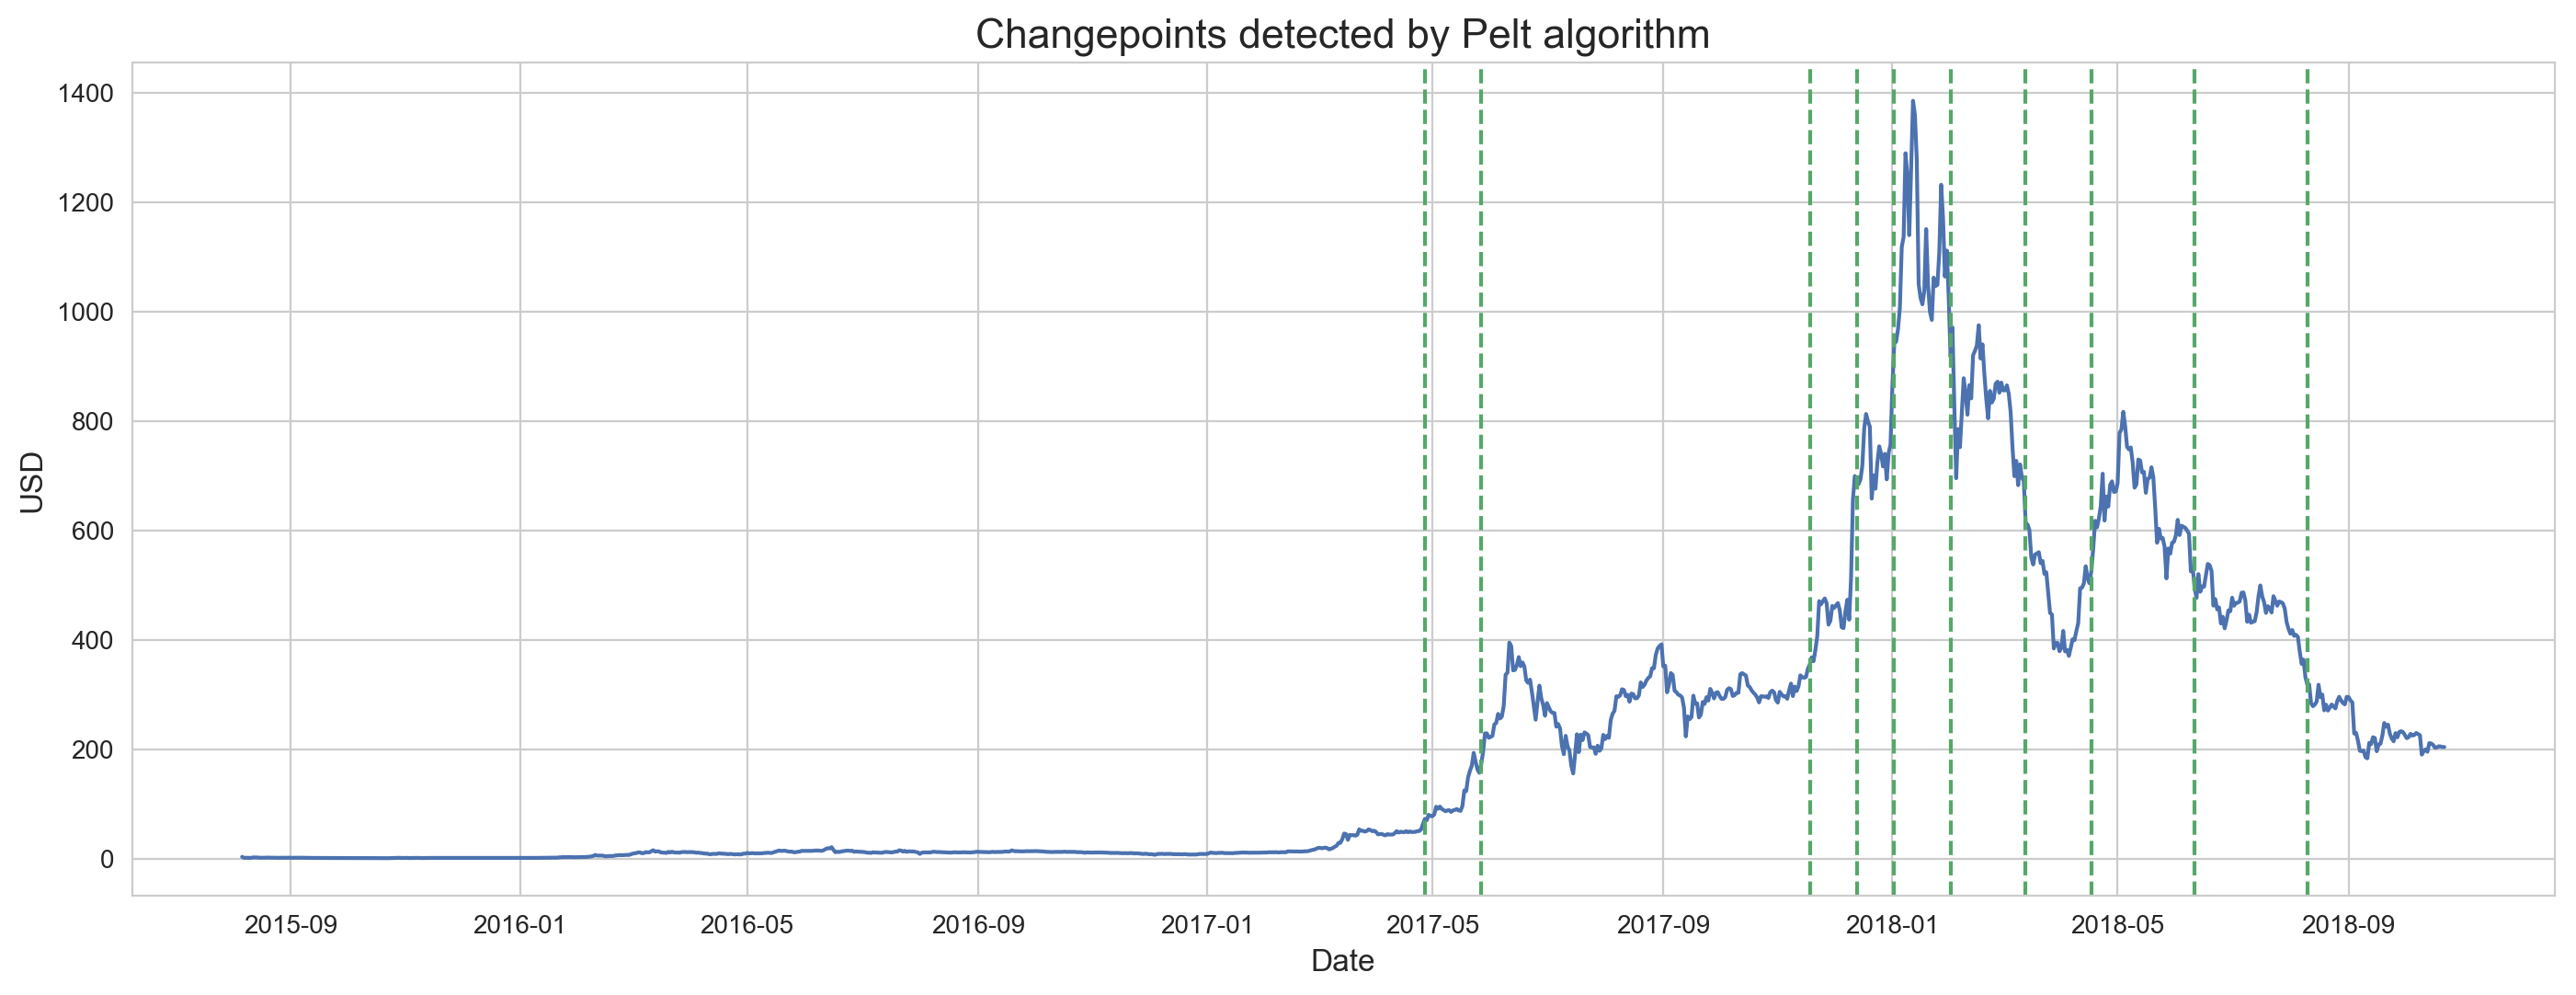

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted by Prophet:
[38, 75, 113, 150, 188, 225, 263, 300, 338, 375, 413, 450, 488, 525, 563, 600, 638, 675, 713, 750, 788, 825, 863, 900, 938]


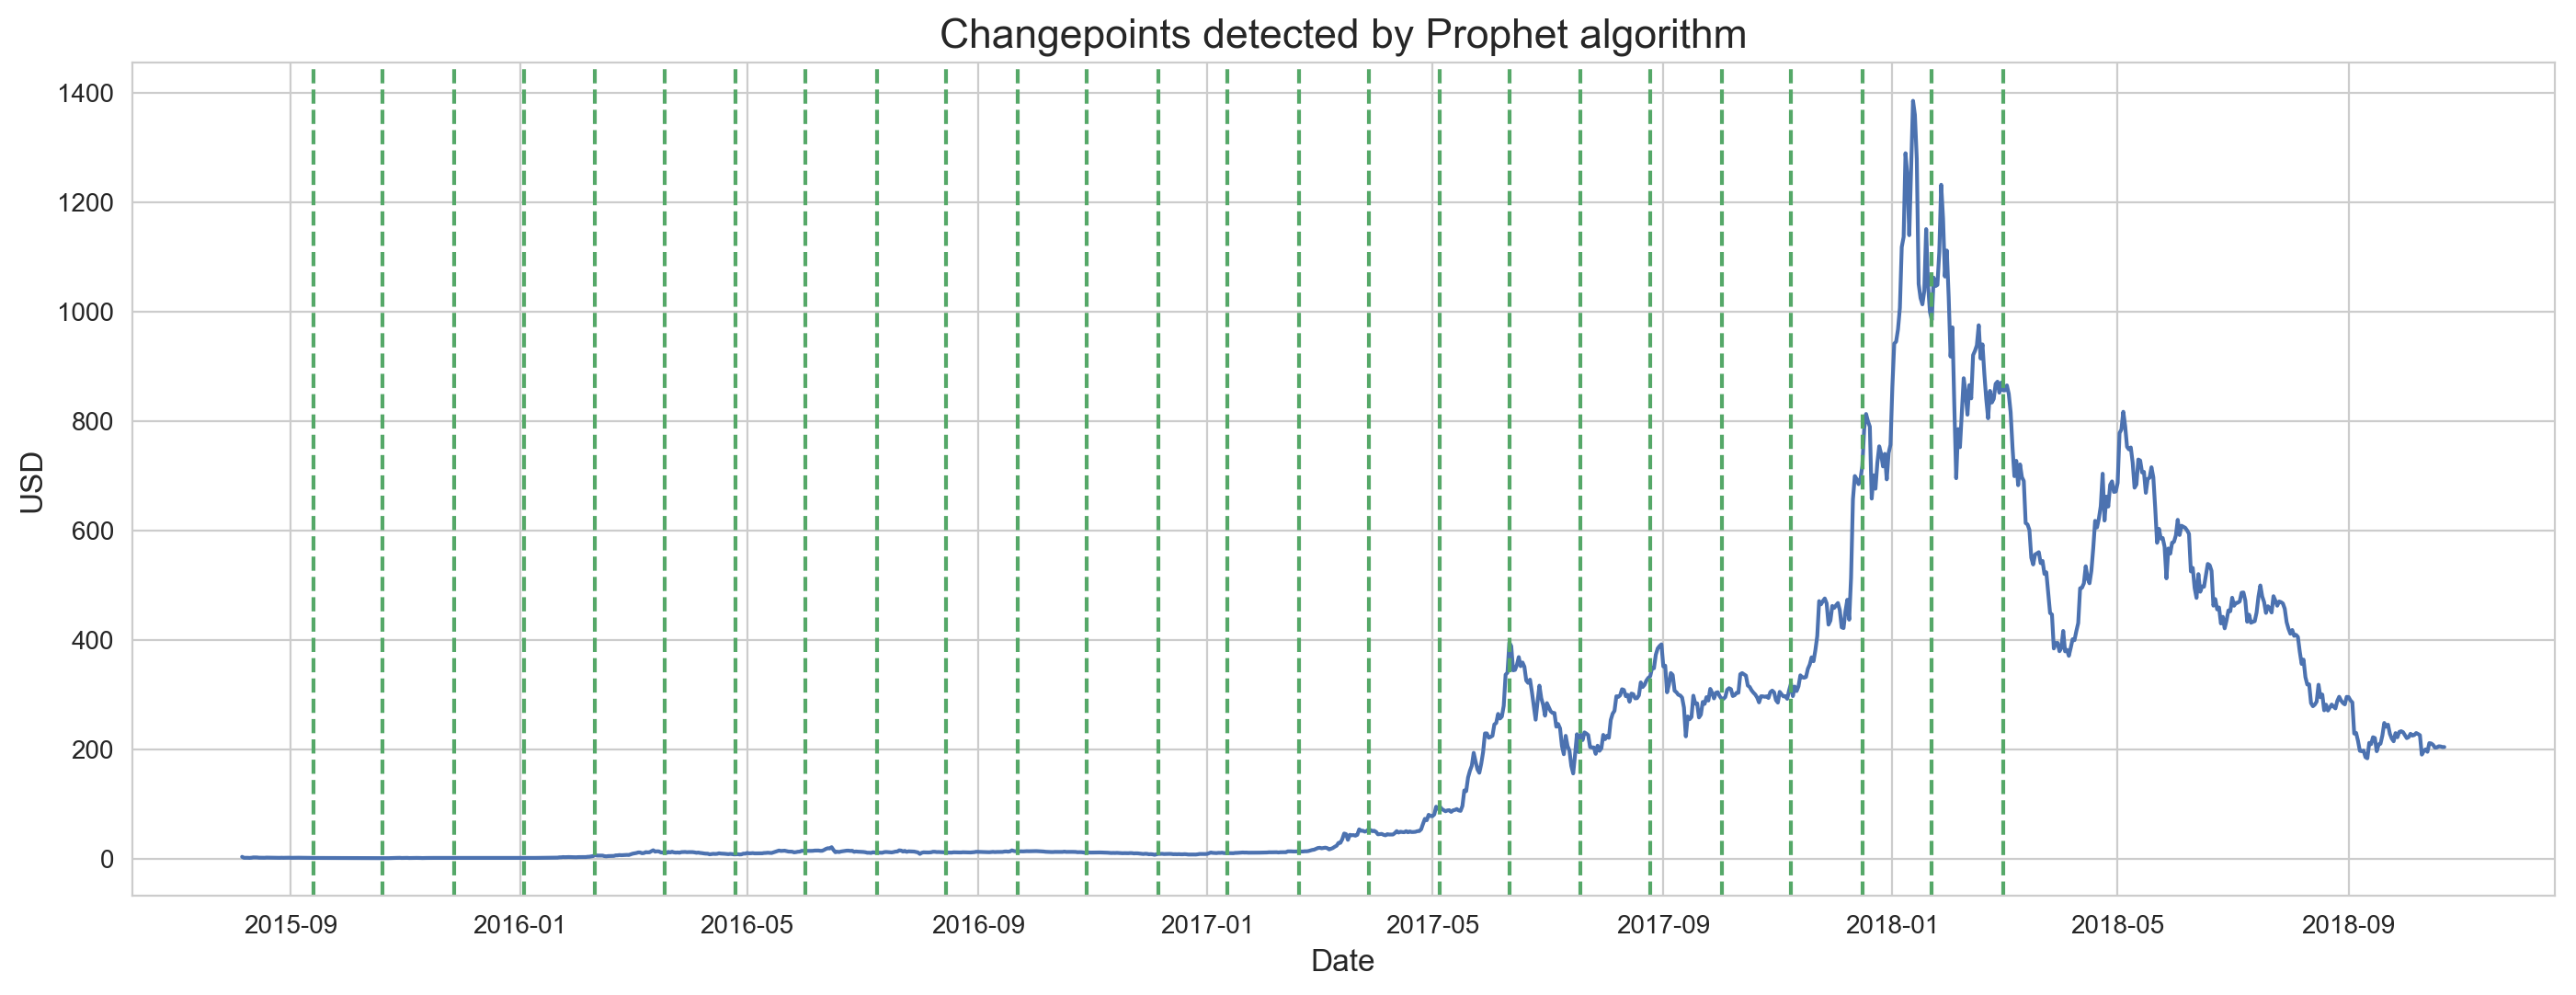

In [4]:
cpts_pelt = get_changepoints(df=ts, algorithm='Pelt', plot=True)
cpts_prophet = get_changepoints(df=ts, algorithm='Prophet', plot=True)